# 下面这个代码是看数据的

In [2]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as w
from IPython.display import display, clear_output

# ====== 配置区（保持与原风格一致）======
file_path = "juncheng/wakling 1.5 2 2.5 3 3.5 stair.csv"   # 修改为你的文件路径
# 读取更多你关心的列（先保存备用）
use_cols  = [
    "Time", "imu_RTx", "imu_LTx",
    "imu_1_left_shaking","imu_2_right_shaking","imu_3_left_foot","imu_4_right_foot",
    "M1_torque_command", "M2_torque_command"
]

figsize   = (10, 5)
alpha     = 0.9
linewidth = 1.2
grid      = True

# ====== 工具函数 ======
def make_time_axis(time_series: pd.Series) -> np.ndarray:
    """
    将 Time 列统一转换为以秒为单位、从 0 开始的时间轴。
    支持：全数字（可能是毫秒）、时间戳字符串、其他无法识别时退化为行号。
    """
    t_num = pd.to_numeric(time_series, errors="coerce")
    if t_num.notna().mean() > 0.9:  # 大部分可当数字
        t = t_num.to_numpy()
        dt_med = np.nanmedian(np.diff(t)) if len(t) > 1 else 10.0  # 10ms 仅作占位
        # 若中位采样间隔在 1~1000（疑似毫秒），按毫秒处理
        if 1.0 <= dt_med <= 1000.0:
            return (t - t[0]) / 1000.0
        return (t - t[0])
    # 尝试解析为日期时间
    t_dt = pd.to_datetime(time_series, errors="coerce")
    if t_dt.notna().mean() > 0.9:
        return (t_dt - t_dt.iloc[0]).dt.total_seconds().to_numpy()
    # 兜底：用行号（秒）
    return np.arange(len(time_series), dtype=float)

def robust_read_csv(path, usecols):
    last_err = None
    for sep in ["\t", None, ","]:  # 先试制表符，再自动推断，最后逗号
        try:
            return pd.read_csv(path, sep=sep, engine="python", usecols=usecols, on_bad_lines="skip")
        except Exception as e:
            last_err = e
    raise RuntimeError(f"读取失败，请检查文件/分隔符/列名是否正确：{last_err}")

def finite_diff(y: np.ndarray, t: np.ndarray) -> np.ndarray:
    """
    一阶导（角速度）：对 y 关于 t 求导，单位由 y 与 t 决定。
    用 numpy.gradient，边界更稳定；t 是秒，所以角速度是 deg/s。
    """
    return np.gradient(y, t)

# ====== 读取数据 ======
df = robust_read_csv(file_path, use_cols).dropna(how="all").reset_index(drop=True)

# 基本校验
missing = [c for c in use_cols if c not in df.columns]
if missing:
    raise ValueError(f"缺少必要列：{missing}")

# 构造统一时间轴（秒）
t_s = make_time_axis(df["Time"])

# 数值化角度/扭矩
to_f = lambda s: pd.to_numeric(df[s], errors="coerce").to_numpy(dtype=float)
r  = to_f("imu_RTx")
l  = to_f("imu_LTx")
m1 = to_f("M1_torque_command")
m2 = to_f("M2_torque_command")

# 其他角度信号（先保存，不画）
imu_1_left_shaking  = to_f("imu_1_left_shaking")
imu_2_right_shaking = to_f("imu_2_right_shaking")
imu_3_left_foot     = to_f("imu_3_left_foot")
imu_4_right_foot    = to_f("imu_4_right_foot")

# 去掉全 NaN 行（按 t_s 对齐）
mask_valid = ~(np.isnan(r) & np.isnan(l) & np.isnan(m1) & np.isnan(m2))
t_s = t_s[mask_valid]
r   = r[mask_valid]; l = l[mask_valid]
m1  = m1[mask_valid]; m2 = m2[mask_valid]
imu_1_left_shaking  = imu_1_left_shaking[mask_valid]
imu_2_right_shaking = imu_2_right_shaking[mask_valid]
imu_3_left_foot     = imu_3_left_foot[mask_valid]
imu_4_right_foot    = imu_4_right_foot[mask_valid]

# —— 计算“imu_RTx 的角速度”（deg/s），用于第三根曲线 ——
r_vel = finite_diff(r, t_s)

# ====== 交互控件：选择 time frame（秒）======
dt_med = np.nanmedian(np.diff(t_s)) if len(t_s) > 1 else 0.01
step   = max(dt_med, 1e-3)

time_slider = w.FloatRangeSlider(
    value=[float(np.nanmin(t_s)), float(np.nanmax(t_s))],
    min=float(np.nanmin(t_s)), max=float(np.nanmax(t_s)),
    step=float(step),
    description="Time (s)",
    readout_format=".3f",
    layout=w.Layout(width="80%")
)
btn = w.Button(description="重绘", button_style="primary")
out = w.Output()
display(w.HBox([time_slider, btn]), out)

def plot_triple(ax_left, t, angle, torque, vel,
                angle_label, torque_label, vel_label, title):
    """
    单图三轴：
      - 左轴：angle（角度，deg）
      - 右轴：torque（扭矩，Nm）
      - 右侧外移第三轴：vel（角速度，deg/s）
    """
    # 右侧第一个轴：扭矩
    ax_right = ax_left.twinx()
    # 右侧第二个轴（外移）：角速度
    ax_vel = ax_left.twinx()
    ax_vel.spines["right"].set_position(("outward", 60))
    ax_vel.set_frame_on(True)
    ax_vel.patch.set_visible(False)

    line_angle,  = ax_left.plot(t, angle,  label=angle_label,
                                color="tab:blue", alpha=alpha, linewidth=linewidth)
    line_torque, = ax_right.plot(t, torque, label=torque_label,
                                 color="tab:red", alpha=alpha, linewidth=linewidth)
    line_vel,    = ax_vel.plot(t, vel,    label=vel_label,
                               color="tab:green", alpha=alpha, linewidth=linewidth)

    ax_left.set_xlabel("Time (s)")
    ax_left.set_ylabel("Angle (deg)", color="tab:blue")
    ax_right.set_ylabel("Torque (Nm)", color="tab:red")
    ax_vel.set_ylabel("Angular velocity (deg/s)", color="tab:green")

    ax_left.tick_params(axis="y", labelcolor="tab:blue")
    ax_right.tick_params(axis="y", labelcolor="tab:red")
    ax_vel.tick_params(axis="y", labelcolor="tab:green")

    if grid:
        ax_left.grid(True, linestyle="--", alpha=0.4)

    ax_left.set_title(title)

    # 合并图例（从三个轴收集句柄）
    handles = [line_angle, line_torque, line_vel]
    labels  = [angle_label, torque_label, vel_label]
    ax_left.legend(handles, labels, loc="upper right")

def redraw(_=None):
    with out:
        clear_output(wait=True)

        t0, t1 = time_slider.value
        sel = (t_s >= t0) & (t_s <= t1)
        if sel.sum() < 2:
            print("选定的时间段数据点太少，请扩大范围。")
            return

        t = t_s[sel]
        r_sel  = r[sel]
        m1_sel = m1[sel]
        rvel_sel = r_vel[sel]

        # 图：imu_RTx (角度) vs M1_torque_command (扭矩) + imu_RTx 角速度
        fig, ax = plt.subplots(figsize=figsize)
        plot_triple(
            ax, t,
            angle=r_sel,
            torque=m1_sel,             # 需要取负就改为 -m1_sel
            vel=rvel_sel,
            angle_label="imu_RTx (deg)",
            torque_label="M1_torque_command (Nm)",
            vel_label="imu_RTx velocity (deg/s)",
            title=f"imu_RTx vs M1_torque + imu_RTx velocity — [{t0:.3f}s, {t1:.3f}s]"
        )
        plt.tight_layout()
        plt.show()

btn.on_click(redraw)
time_slider.observe(redraw, names="value")
redraw()




Output()

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as w
from IPython.display import display, clear_output

# ====== 配置区（与前面风格一致）======
file_path = "juncheng/wakling 1.5 2 2.5 3 3.5 stair.csv"   # 修改为你的文件路径
use_cols  = ["Time", "imu_3_left_foot", "imu_4_right_foot"]

figsize   = (10, 5)
alpha     = 0.9
linewidth = 1.2
grid      = True

# ====== 工具函数 ======
def make_time_axis(time_series: pd.Series) -> np.ndarray:
    """
    将 Time 列统一转换为以秒为单位、从 0 开始的时间轴。
    支持：全数字（可能是毫秒）、时间戳字符串、其他无法识别时退化为行号。
    """
    t_num = pd.to_numeric(time_series, errors="coerce")
    if t_num.notna().mean() > 0.9:  # 大部分可当数字
        t = t_num.to_numpy()
        dt_med = np.nanmedian(np.diff(t)) if len(t) > 1 else 10.0
        # 若中位采样间隔在 1~1000（疑似毫秒），按毫秒处理
        if 1.0 <= dt_med <= 1000:
            return (t - t[0]) / 1000.0
        return (t - t[0])
    # 尝试解析为日期时间
    t_dt = pd.to_datetime(time_series, errors="coerce")
    if t_dt.notna().mean() > 0.9:
        return (t_dt - t_dt.iloc[0]).dt.total_seconds().to_numpy()
    # 兜底：用行号
    return np.arange(len(time_series), dtype=float)

def robust_read_csv(path, usecols):
    last_err = None
    for sep in ["\t", None, ","]:  # 先试制表符，再自动推断，最后逗号
        try:
            return pd.read_csv(path, sep=sep, engine="python", usecols=usecols, on_bad_lines="skip")
        except Exception as e:
            last_err = e
    raise RuntimeError(f"读取失败，请检查文件/分隔符/列名是否正确：{last_err}")

# ====== 读取数据 ======
df = robust_read_csv(file_path, use_cols).dropna(how="all").reset_index(drop=True)

# 基本校验
missing = [c for c in use_cols if c not in df.columns]
if missing:
    raise ValueError(f"缺少必要列：{missing}")

# 构造统一时间轴（秒）
t_s = make_time_axis(df["Time"])

# 数值化角度
lf = pd.to_numeric(df["imu_3_left_foot"], errors="coerce").to_numpy(dtype=float)
rf = pd.to_numeric(df["imu_4_right_foot"], errors="coerce").to_numpy(dtype=float)

# 去掉左右脚同时 NaN 的点（按 t_s 对齐）
mask = ~(np.isnan(lf) & np.isnan(rf))
t_s = t_s[mask]; lf = lf[mask]; rf = rf[mask]

# ====== 交互控件：选择 time frame（秒）======
dt_med = np.nanmedian(np.diff(t_s)) if len(t_s) > 1 else 0.01
step   = max(float(dt_med), 1e-3)

time_slider = w.FloatRangeSlider(
    value=[float(np.nanmin(t_s)), float(np.nanmax(t_s))],
    min=float(np.nanmin(t_s)), max=float(np.nanmax(t_s)),
    step=step,
    description="Time (s)",
    readout_format=".3f",
    layout=w.Layout(width="80%")
)
btn = w.Button(description="重绘", button_style="primary")
out = w.Output()
display(w.HBox([time_slider, btn]), out)

def redraw(_=None):
    with out:
        clear_output(wait=True)

        t0, t1 = time_slider.value
        sel = (t_s >= t0) & (t_s <= t1)
        if sel.sum() < 2:
            print("选定的时间段数据点太少，请扩大范围。")
            return

        t = t_s[sel]; lf_sel = lf[sel]; rf_sel = rf[sel]

        fig, ax = plt.subplots(figsize=figsize)
        line_lf, = ax.plot(t, lf_sel, label="imu_3_left_foot (deg)",
                           color="tab:blue", alpha=alpha, linewidth=linewidth)
        line_rf, = ax.plot(t, rf_sel, label="imu_4_right_foot (deg)",
                           color="tab:orange", alpha=alpha, linewidth=linewidth)

        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Foot Angle (deg)")
        if grid:
            ax.grid(True, linestyle="--", alpha=0.4)
        ax.set_title(f"Left/Right Foot Angles — [{t0:.3f}s, {t1:.3f}s]")

        ax.legend(loc="upper right")
        plt.tight_layout()
        plt.show()

btn.on_click(redraw)
time_slider.observe(redraw, names="value")
redraw()




Output()

In [5]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np

# ========= 1) 配置 =========
file_path   = "juncheng/wakling 1.5 2 2.5 3 3.5 stair.csv"   # 你的原始文件
output_path = file_path                      # 允许覆盖写入；想生成新文件就改别名

# 期望的 label 与其起止时间窗口（任意个；顺序随意）
# speed: 想展示在标签里的速度文本（字符串或数字）；
# start/end: 起止时间；
# unit: "ms" 或 "s"（也可以统一在下面 TIME_WINDOWS_UNIT 指定）
SPEED_WINDOWS = [
    {"speed": "6", "start": 710000, "end": 720000, "unit": "ms"},
    {"speed": "4", "start": 660000, "end": 670000, "unit": "ms"},
    {"speed": "3", "start": 620000, "end": 630000, "unit": "ms"},
    {"speed": "2", "start": 580000, "end": 590000, "unit": "ms"},
    {"speed": "1", "start": 540000, "end": 546000, "unit": "ms"},
    {"speed": "10", "start": 485000, "end": 495000, "unit": "ms"},
    {"speed": "8", "start": 440000, "end": 450000, "unit": "ms"},
    {"speed": "6.1", "start": 385000, "end": 395000, "unit": "ms"},



]

# SPEED_WINDOWS = [
#     {"speed": "2", "start": 115000, "end": 130000, "unit": "ms"},
#     {"speed": "3", "start": 155000, "end": 170000, "unit": "ms"},
#     {"speed": "4", "start": 189000, "end": 197000, "unit": "ms"},
#     {"speed": "5", "start": 215000, "end": 225000, "unit": "ms"},
#     {"speed": "6", "start": 269000, "end": 278000, "unit": "ms"},
#     {"speed": "7", "start": 300000, "end": 320000, "unit": "ms"},
#     {"speed": "7.1", "start": 385000, "end": 395000, "unit": "ms"},
#     {"speed": "8", "start": 415000, "end": 425000, "unit": "ms"},
#     {"speed": "9", "start": 460000, "end": 470000, "unit": "ms"},
#     {"speed": "10", "start": 505000, "end": 515000, "unit": "ms"},
#     {"speed": "11", "start": 550000, "end": 560000, "unit": "ms"},
#     {"speed": "12", "start": 590000, "end": 600000, "unit": "ms"},
#     {"speed": "13", "start": 616000, "end": 626000, "unit": "ms"},
#     {"speed": "14", "start": 705000, "end": 715000, "unit": "ms"},
#     {"speed": "15", "start": 725000, "end": 735000, "unit": "ms"},


# ]
LABEL_FORMAT = "{speed}km/h"        # 生成标签的格式；可改成 "{speed}" 或 "{speed} mph"
DEFAULT_LABEL = "n/a"

# 如果你不想在每个窗口里都写 unit，可用这里统一指定（"auto" / "ms" / "s"）
TIME_WINDOWS_UNIT = "ms"            # 推荐与上面一致；写 "auto" 则忽略本项

# ========= 2) 工具 =========
def find_time_col(df):
    for c in df.columns:
        if str(c).lower().startswith("time"):
            return c
    raise ValueError("未找到时间列（例如 Time/time/timestamp）")

def series_to_seconds(series: pd.Series) -> np.ndarray:
    """把时间列换算成秒，从 0 开始；支持 ms / s / timestamp"""
    tnum = pd.to_numeric(series, errors="coerce")
    if tnum.notna().mean() > 0.9:
        t = tnum.to_numpy(dtype=float)
        t = t - np.nanmin(t)
        if len(t) > 1 and np.nanmedian(np.diff(t)) > 1.0:  # 典型 ms
            t = t / 1000.0
        return t
    tdt = pd.to_datetime(series, errors="coerce")
    if tdt.notna().mean() > 0.9:
        t = (tdt - tdt.min()).dt.total_seconds().to_numpy()
        return t
    # 兜底：用索引
    return np.arange(len(series), dtype=float)

def to_seconds(x, unit: str):
    if unit is None:
        return float(x)
    unit = unit.lower()
    if unit in ("ms", "millisecond", "milliseconds"):
        return float(x) / 1000.0
    if unit in ("s", "sec", "second", "seconds"):
        return float(x)
    raise ValueError(f"不支持的时间单位：{unit}")

def normalize_windows(win_list, default_unit=None):
    """把窗口统一换算到秒，并生成最终 label 文本"""
    out = []
    for w in win_list:
        speed = str(w["speed"])
        unit  = (w.get("unit") or default_unit or "s").lower()
        start_s = to_seconds(w["start"], unit)
        end_s   = to_seconds(w["end"],   unit)
        if end_s <= start_s:
            raise ValueError(f"区间无效：{w}")
        label = LABEL_FORMAT.format(speed=speed)
        out.append({"label": label, "start_s": start_s, "end_s": end_s, "speed": speed})
    # 检查重叠（同一时间覆盖到多个 label）
    out_sorted = sorted(out, key=lambda x: x["start_s"])
    for i in range(len(out_sorted)-1):
        if out_sorted[i]["end_s"] > out_sorted[i+1]["start_s"]:
            raise ValueError(f"检测到重叠区间：{out_sorted[i]}  vs  {out_sorted[i+1]}\n"
                             f"（如需容忍重叠，可改为按顺序覆盖）")
    return out_sorted

# ========= 3) 主流程 =========
df = pd.read_csv(file_path)
time_col = find_time_col(df)
t_sec = series_to_seconds(df[time_col])
df["time_s"] = t_sec  # 保留一列秒级时间，后续分析也方便

# 统一窗口 → 秒
default_unit = None if TIME_WINDOWS_UNIT == "auto" else TIME_WINDOWS_UNIT
win_sec = normalize_windows(SPEED_WINDOWS, default_unit)

# 先设默认标签
df["label"] = DEFAULT_LABEL

# 逐窗口打标签（无重叠，按区间覆盖）
for w in win_sec:
    sel = (df["time_s"] >= w["start_s"]) & (df["time_s"] <= w["end_s"])
    df.loc[sel, "label"] = w["label"]

# 保存（覆盖原文件或另存）
df.to_csv(output_path, index=False)
print("✅ 标签写入完成：", output_path)

# 可选：打印覆盖情况
covered = sum(((df["label"] != DEFAULT_LABEL)).astype(int))
print(f"覆盖样本数：{covered} / {len(df)}  "
      f"({covered/len(df)*100:.1f}%)")
for w in win_sec:
    print(f"- {w['label']}: {w['start_s']:.3f}s → {w['end_s']:.3f}s")


✅ 标签写入完成： juncheng/wakling 1.5 2 2.5 3 3.5 stair.csv
覆盖样本数：7567 / 74870  (10.1%)
- 6.1km/h: 385.000s → 395.000s
- 8km/h: 440.000s → 450.000s
- 10km/h: 485.000s → 495.000s
- 1km/h: 540.000s → 546.000s
- 2km/h: 580.000s → 590.000s
- 3km/h: 620.000s → 630.000s
- 4km/h: 660.000s → 670.000s
- 6km/h: 710.000s → 720.000s


/var/folders/bk/9h6f82g55bx0xch3f1yztl5w0000gn/T/ipykernel_2935/541766917.py:140: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


✅ 已写入： juncheng/wakling 1.5 2 2.5 3 3.5 stair.csv

各速度段识别到的 gait cycles（基于右脚极小值）：
label
1km/h       4
2km/h       5
3km/h       5
4km/h       7
6km/h       9
6.1km/h    11
8km/h      11
10km/h     12
Name: num_cycles, dtype: int64


/var/folders/bk/9h6f82g55bx0xch3f1yztl5w0000gn/T/ipykernel_2935/541766917.py:184: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/bk/9h6f82g55bx0xch3f1yztl5w0000gn/T/ipykernel_2935/541766917.py:222: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gait_change_idx = np.where(np.diff(gait.fillna(method="ffill")) > 0)[0]


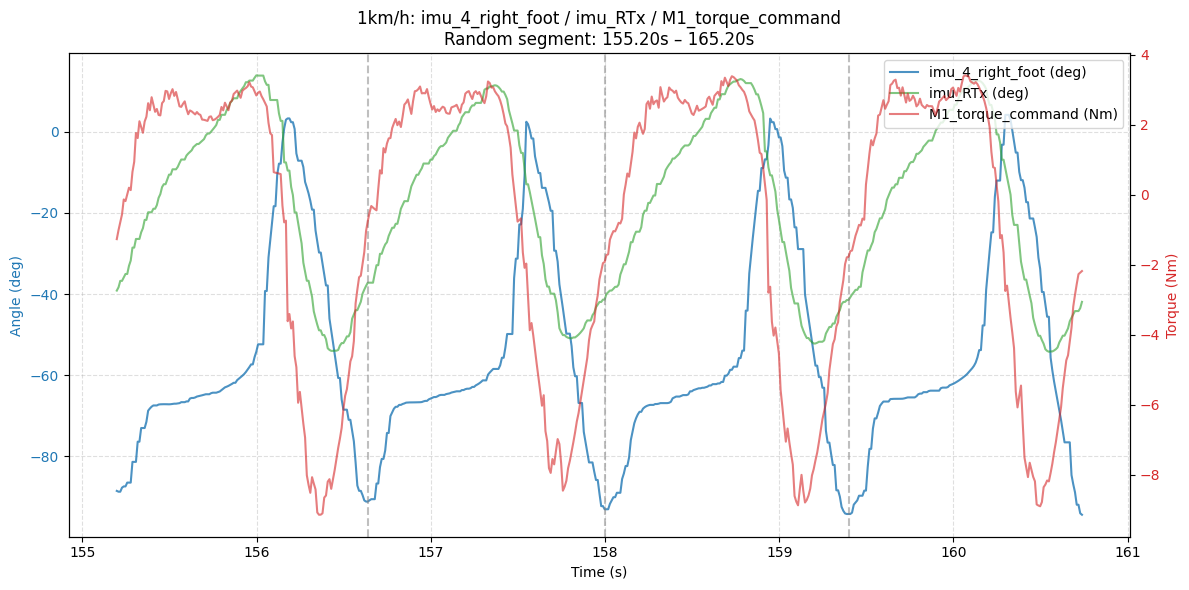

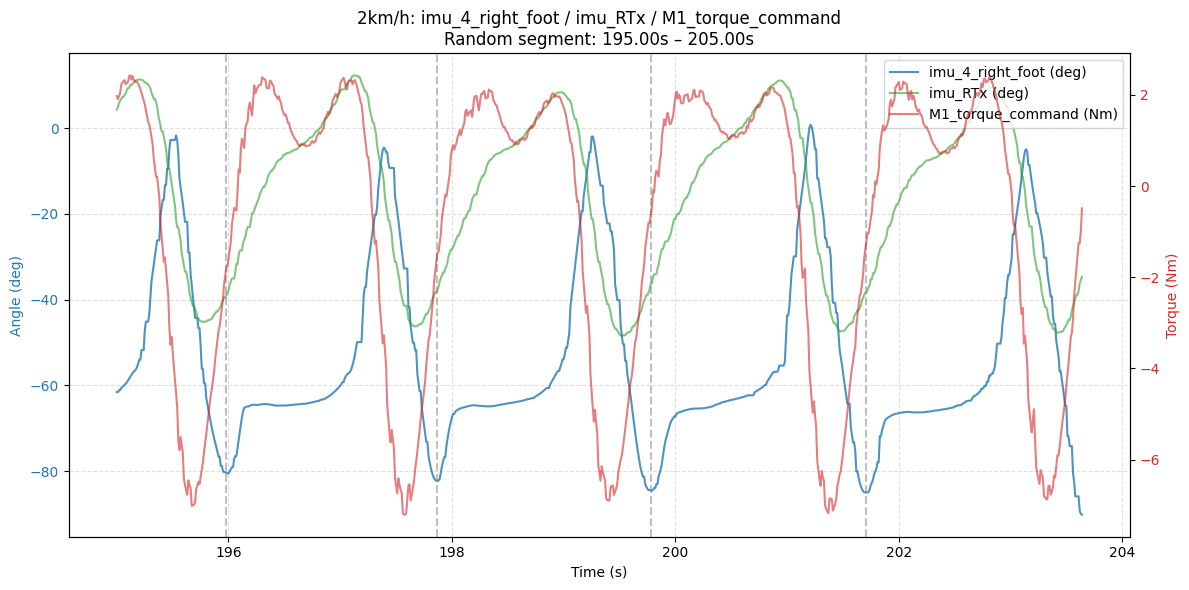

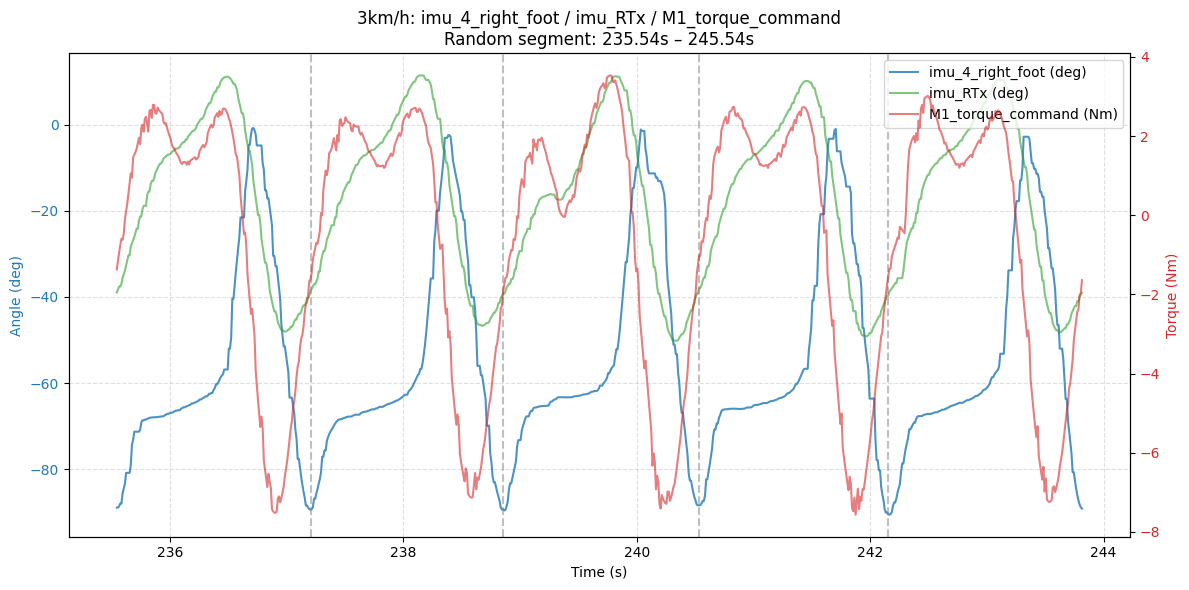

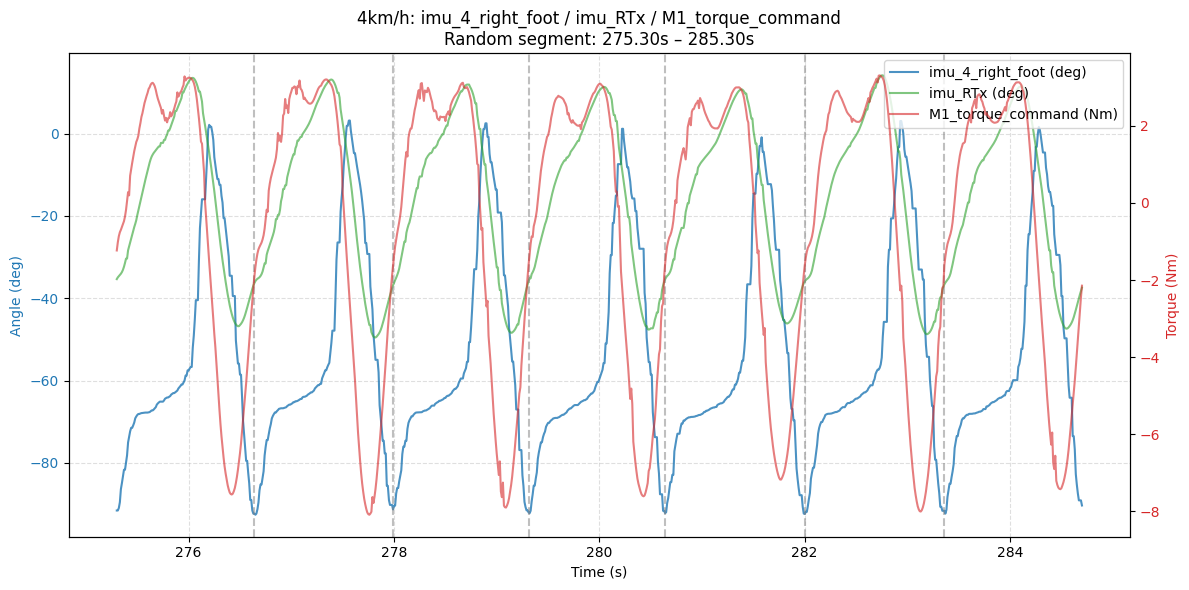

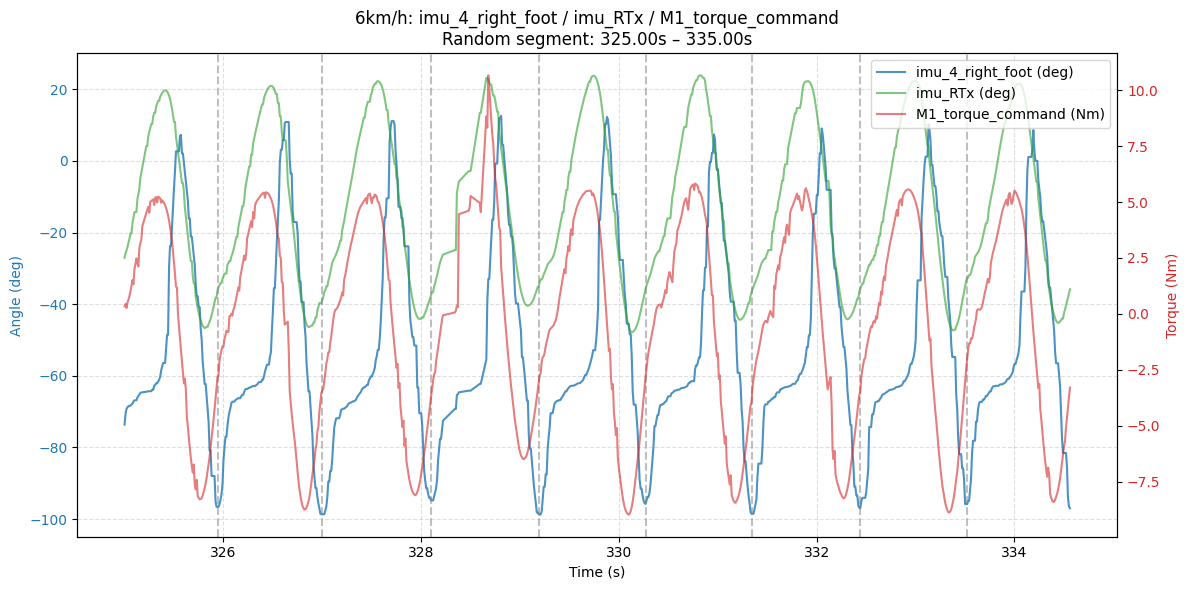

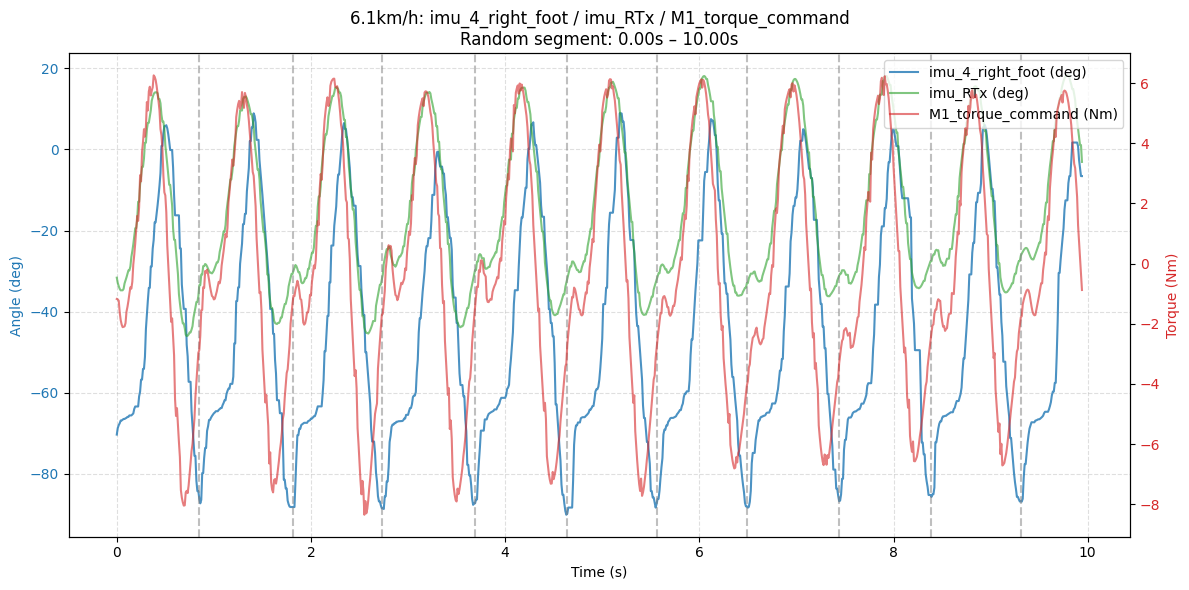

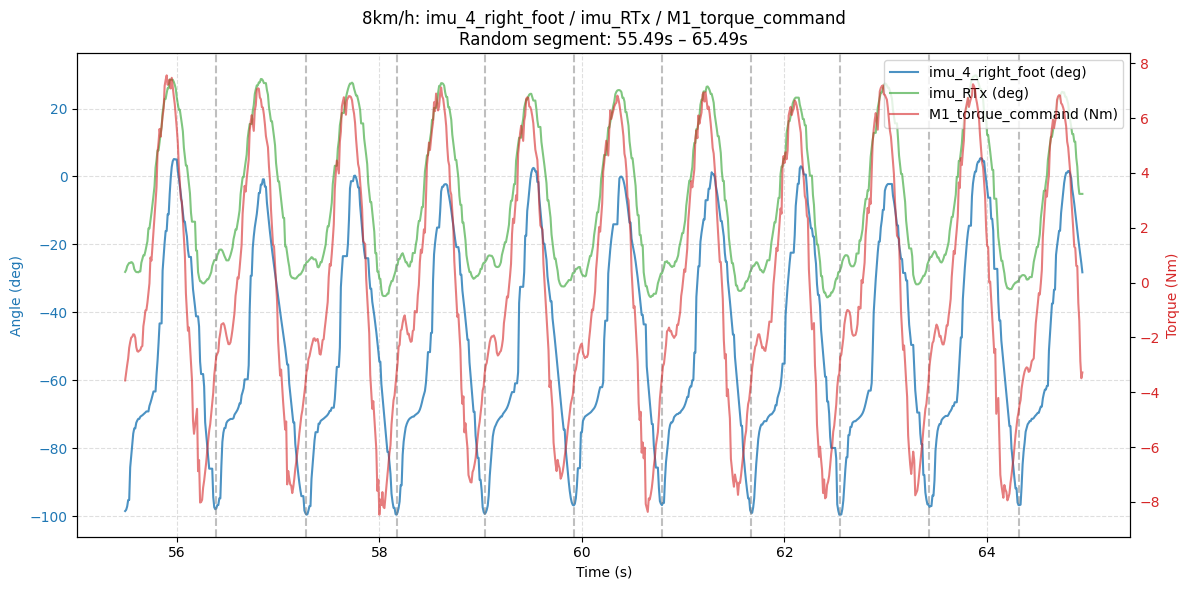

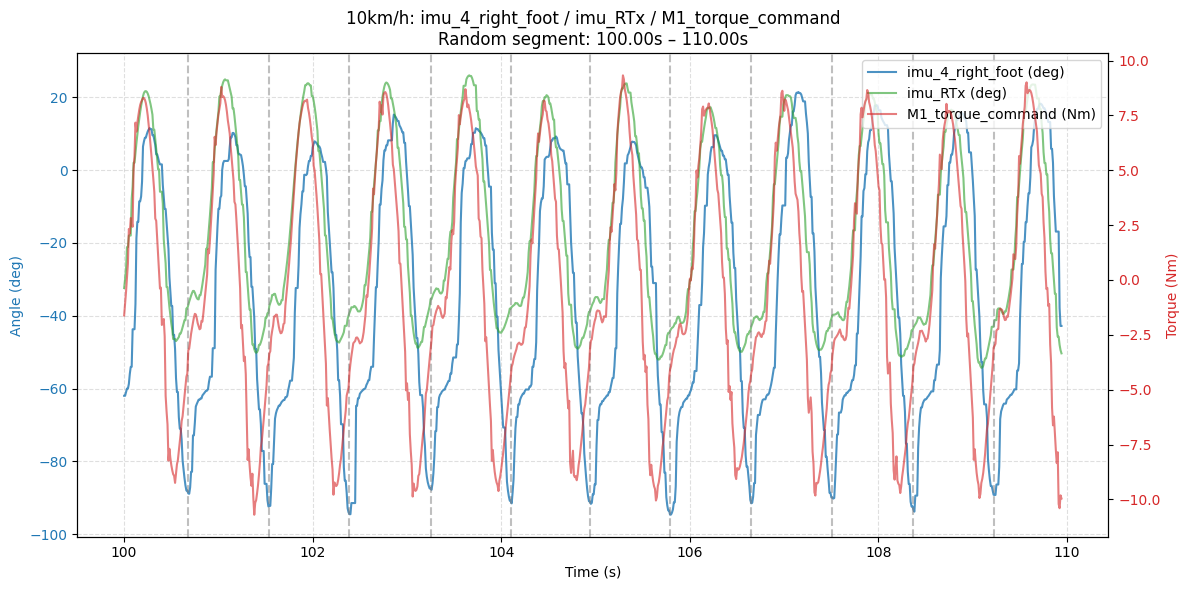

In [6]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
# ========= 配置 =========
file_path   = "juncheng/wakling 1.5 2 2.5 3 3.5 stair.csv"   # 你的原始文件
time_col_guess = ["Time", "time", "timestamp"]      # 自动识别时间列
angle_col  = "imu_4_right_foot"                     # 右脚角度（deg）
label_col  = "label"
labels_to_do = ["1km/h", "2km/h", "3km/h", "4km/h", "6km/h", "6.1km/h", "8km/h", "10km/h", ]        # 需要切分的速度段

# labels_to_do = ["2mile", "3mile", "4mile", "5mile", "6mile", "7mile",  "7.1mile", "8mile", "9mile", "10mile", "11mile", "12mile", "13mile", "14mile", "15mile"]        # 需要切分的速度段
# labels_to_do = ["5mile", "6mile", "7mile", "7.1mile"]        # 需要切分的速度段

# 信号处理/极值检测参数
smooth_win_pts   = 5        # 滑动平均窗口（点数，奇数较好）
min_distance_sec = 0.6      # 相邻极小值的最小时间间隔（秒），跑步机 2~3.5mph 可取 0.6~1.2
prominence_deg   = 2.0      # 极小值“显著性”阈值（单位：度），可适当增大抑制毛刺

# ========= 工具函数 =========
def find_time_column(df, guesses):
    for c in df.columns:
        if c in guesses or c.lower() in [g.lower() for g in guesses] or c.lower().startswith("time"):
            return c
    raise ValueError("未找到时间列，请在 time_col_guess 中加入正确列名。")

def make_time_seconds(series: pd.Series) -> np.ndarray:
    t_num = pd.to_numeric(series, errors="coerce")
    if t_num.notna().mean() > 0.9:
        t = t_num.to_numpy()
        if len(t) > 1:
            dt = np.nanmedian(np.diff(t))
        else:
            dt = 10.0
        return (t - t[0]) / (1000.0 if 1.0 <= dt <= 1000.0 else 1.0)
    t_dt = pd.to_datetime(series, errors="coerce")
    if t_dt.notna().mean() > 0.9:
        return (t_dt - t_dt.iloc[0]).dt.total_seconds().to_numpy()
    return np.arange(len(series), dtype=float)

def moving_average(x, win):
    win = int(max(1, win))
    if win == 1: return x
    k = np.ones(win) / win
    return np.convolve(x, k, mode="same")

def minima_indices_numpy(y, distance_pts=1, prominence=0.0):
    """
    纯 numpy：通过一阶差分符号变化找到极小值，再做简单去噪。
    - distance_pts: 相邻极小值的最小点数间隔
    - prominence  : 仅保留比邻域中值至少低 prominence 的点
    """
    dy = np.diff(y)
    sign = np.sign(dy)
    # 从负到正：局部极小值
    candidates = np.where((sign[:-1] < 0) & (sign[1:] > 0))[0] + 1
    if candidates.size == 0:
        return candidates

    # 简单“prominence”：和邻域中位数比较
    if prominence > 0:
        keep = []
        half = max(3, distance_pts // 2)
        for idx in candidates:
            a = max(0, idx-half)
            b = min(len(y), idx+half+1)
            med = np.median(y[a:b])
            if (med - y[idx]) >= prominence:
                keep.append(idx)
        candidates = np.array(keep, dtype=int)

    # 距离抑制：若太近，保留更“低”的那个
    if candidates.size > 1 and distance_pts > 1:
        kept = [candidates[0]]
        for i in range(1, len(candidates)):
            if candidates[i] - kept[-1] < distance_pts:
                # 取更低的极小值
                if y[candidates[i]] < y[kept[-1]]:
                    kept[-1] = candidates[i]
            else:
                kept.append(candidates[i])
        candidates = np.array(kept, dtype=int)

    return candidates

def find_minima(y, t, min_distance_sec, prominence_deg):
    """
    优先使用 scipy.signal.find_peaks(-y, ...)，如无 scipy 则回退到 numpy 实现。
    """
    distance_pts = max(1, int(np.round(min_distance_sec / max(1e-6, np.nanmedian(np.diff(t))))))

    try:
        from scipy.signal import find_peaks
        peaks, prop = find_peaks(-y, distance=distance_pts, prominence=prominence_deg)
        return peaks
    except Exception:
        return minima_indices_numpy(y, distance_pts=distance_pts, prominence=prominence_deg)

def assign_cycles_by_minima(df, t_col, y_col, label_col, label_value,
                            smooth_win_pts=1, min_distance_sec=0.7, prominence_deg=2.0):
    """
    在 df 中针对某个 label（label_value），
    用 y_col 的极小值序列切分区间，并填充 gait_cycle=1,2,3,...
    返回被修改后的 df（就地赋值）
    """
    sel = (df[label_col] == label_value) & df[y_col].notna()
    if sel.sum() < 5:
        return df  # 数据太少，跳过

    t = df.loc[sel, t_col].to_numpy()
    y = df.loc[sel, y_col].astype(float).to_numpy()

    # 平滑
    ys = moving_average(y, smooth_win_pts)

    # 极小值（步态开始点序列）
    mins = find_minima(ys, t, min_distance_sec=min_distance_sec, prominence_deg=prominence_deg)
    if len(mins) < 2:
        # 极小值太少，无法切分
        return df

    # 从第一个极小值作为周期1开始，到最后一个极小值之前结束
    local_idx = np.where(sel)[0]          # 全局行号（该 label 的所有行）
    starts = mins[:-1]
    ends   = mins[1:]

    # 逐段赋值 1,2,3,...
    gait_ids = np.full(sel.sum(), np.nan)
    for k, (a, b) in enumerate(zip(starts, ends), start=1):
        gait_ids[a:b] = k

    # 回写到原表
    df.loc[local_idx, "gait_cycle"] = gait_ids
    return df

# ========= 主流程 =========
df = pd.read_csv(file_path)

# 时间列
t_col = find_time_column(df, time_col_guess)
df["_time_s"] = make_time_seconds(df[t_col])

# 统一准备列
if angle_col not in df.columns:
    raise ValueError(f"未找到角度列：{angle_col}")
if label_col not in df.columns:
    raise ValueError(f"未找到标签列：{label_col}")

# 新增列（先置 NaN）
df["gait_cycle"] = np.nan

# 逐个速度段切分
for lb in labels_to_do:
    df = assign_cycles_by_minima(
        df, t_col="_time_s", y_col=angle_col, label_col=label_col, label_value=lb,
        smooth_win_pts=smooth_win_pts, min_distance_sec=min_distance_sec, prominence_deg=prominence_deg
    )

# 保存
out_path = file_path.replace(".csv", ".csv")
df.to_csv(out_path, index=False)
print("✅ 已写入：", out_path)

# 简要统计（每个速度段的周期数）
summary = (df.dropna(subset=["gait_cycle"])
             .groupby(label_col)["gait_cycle"]
             .max()
             .rename("num_cycles")
             .reindex(labels_to_do)
          )
print("\n各速度段识别到的 gait cycles（基于右脚极小值）：")
print(summary.fillna(0).astype(int))


##############################################################################
labels_to_show = labels_to_do
window_duration = 10.0   # 每段随机选取10秒窗口
figsize = (12, 6)

# ========= 读取数据 =========
df = pd.read_csv(file_path)
df = df.dropna(subset=["label", "gait_cycle"])  # 只保留标好步态的行
if "Time" in df.columns:
    t = pd.to_numeric(df["Time"], errors="coerce")
    if t.max() > 1000:  # ms -> s
        t = (t - t.iloc[0]) / 1000.0
    else:
        t = t - t.iloc[0]
else:
    raise ValueError("未找到 Time 列")

df["time_s"] = t

# ========= 辅助函数 =========
def plot_segment(data, label_name):
    """随机选择一个label段落并绘图"""
    subset = data[data["label"] == label_name].copy()
    if subset.empty:
        print(f"⚠️ 无数据: {label_name}")
        return
    
    tmin, tmax = subset["time_s"].min(), subset["time_s"].max()
    duration = tmax - tmin
    if duration <= window_duration:
        start_t = tmin
    else:
        start_t = random.uniform(tmin, tmax - window_duration)
    end_t = start_t + window_duration
    sub = subset[(subset["time_s"] >= start_t) & (subset["time_s"] <= end_t)]

    # 准备数据
    time = sub["time_s"]
    foot = pd.to_numeric(sub["imu_4_right_foot"], errors="coerce")
    hip = pd.to_numeric(sub["imu_RTx"], errors="coerce")
    torque = pd.to_numeric(sub["M1_torque_command"], errors="coerce")
    gait = pd.to_numeric(sub["gait_cycle"], errors="coerce")

    # 找到gait_cycle变化点
    gait_change_idx = np.where(np.diff(gait.fillna(method="ffill")) > 0)[0]
    gait_change_t = time.iloc[gait_change_idx + 1].to_numpy()

    # 绘图
    fig, ax1 = plt.subplots(figsize=figsize)
    ax2 = ax1.twinx()

    ax1.plot(time, foot, label="imu_4_right_foot (deg)", color="tab:blue", alpha=0.8)
    ax1.plot(time, hip, label="imu_RTx (deg)", color="tab:green", alpha=0.6)
    ax2.plot(time, torque, label="M1_torque_command (Nm)", color="tab:red", alpha=0.6)

    # gait 边界线
    for tt in gait_change_t:
        ax1.axvline(tt, color="gray", linestyle="--", alpha=0.5)

    # 图例与标签
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Angle (deg)", color="tab:blue")
    ax2.set_ylabel("Torque (Nm)", color="tab:red")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    ax1.grid(True, linestyle="--", alpha=0.4)
    ax1.set_title(f"{label_name}: imu_4_right_foot / imu_RTx / M1_torque_command\n"
                  f"Random segment: {start_t:.2f}s – {end_t:.2f}s")

    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

    plt.tight_layout()
    plt.show()

# ========= 执行绘制 =========
for lb in labels_to_show:
    plot_segment(df, lb)



In [ ]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as w
from IPython.display import display, clear_output

SUBJECTS = "juncheng"
SUBJECTS_LIST = ["juncheng"]
BASENAME = "wakling 1.5 2 2.5 3 3.5 stair.csv"

TIME_CANDIDATES = ["Time", "time", "timestamp"]
ANGLE_COLS = ["imu_RTx", "imu_LTx"]      # 需要求导的角度列
CUTOFF_HZ = 2.0                          # 低通截止频率
FILTER_ORDER = 4

def find_time_col(df):
    for c in df.columns:
        if c in TIME_CANDIDATES or c.lower().startswith("time"):
            return c
    raise ValueError("未找到时间列（如 Time/time/timestamp）")

def time_to_seconds(t_series: pd.Series) -> np.ndarray:
    t = pd.to_numeric(t_series, errors="coerce").to_numpy(dtype=float)
    t = t - np.nanmin(t)
    dt = np.nanmedian(np.diff(t[np.isfinite(t)])) if len(t) > 1 else np.nan
    if np.isnan(dt) or dt == 0:
        # 兜底：用索引代替时间（避免除以 0）
        return np.arange(len(t), dtype=float)
    # 判断是否是毫秒
    if dt > 1.0:
        t = t / 1000.0
    return t

def finite_diff(y, t):
    return np.gradient(y, t)
def moving_average(x, window_size=15):
    """
    简单滑动平均平滑（中心对齐，NaN 自动忽略）
    window_size 越大越平滑；建议范围 5~25
    """
    x = np.asarray(x, dtype=float)
    nans = ~np.isfinite(x)
    if nans.any():
        idx = np.arange(len(x))
        x[nans] = np.interp(idx[nans], idx[~nans], x[~nans])
    kernel = np.ones(window_size) / window_size
    y = np.convolve(x, kernel, mode="same")
    y[nans] = np.nan
    return y

def butter_lowpass(x, cutoff_hz, fs, order=4):
    # 防御：确保 cutoff < Nyquist
    nyq = 0.5 * fs
    c = min(cutoff_hz, nyq * 0.99) if nyq > 0 else cutoff_hz
    if c <= 0 or nyq <= 0:
        return x
    b, a = butter(order, c / nyq, btype="low", analog=False)
    # filtfilt 不能出现 NaN；先线性插值再滤波，最后把原 NaN 放回去
    x = np.asarray(x, dtype=float)
    nans = ~np.isfinite(x)
    if nans.any():
        idx = np.arange(len(x))
        x[nans] = np.interp(idx[nans], idx[~nans], x[~nans])
    # padlen 防御：数据太短时直接返回原始
    padlen = 3 * max(len(a), len(b))
    if len(x) <= padlen:
        return x
    xf = filtfilt(b, a, x)
    xf[nans] = np.nan  # 按需放回 NaN（也可不放回）
    return xf

def process_file(file_path):
    if not os.path.exists(file_path):
        print(f"❌ 找不到文件：{file_path}")
        return
    df = pd.read_csv(file_path)
    time_col = find_time_col(df)
    t = time_to_seconds(df[time_col])
    # 采样率
    dt = np.nanmedian(np.diff(t[np.isfinite(t)])) if len(t) > 1 else np.nan
    fs = 1.0 / dt if (dt and dt > 0) else np.nan
    print(f"→ {file_path} | 采样率估计: {fs:.2f} Hz")

    for col in ANGLE_COLS:
        if col not in df.columns:
            print(f"  ⚠️ 缺少列 {col}，跳过该列")
            continue
        y = pd.to_numeric(df[col], errors="coerce").to_numpy(dtype=float)
        vel = finite_diff(y, t)               # deg/s
        vel *= np.pi/180.0
        if np.isfinite(fs):
            # vel = butter_lowpass(vel, CUTOFF_HZ, fs, FILTER_ORDER)
            vel = vel

        df[f"{col}_velocity"] = vel

    out_path = os.path.join(os.path.dirname(file_path),
                            os.path.basename(file_path).replace(".csv", ".csv"))
    df.to_csv(out_path, index=False)
    print(f"✅ 输出：{out_path}")
    print(f"   新增列：{[f'{c}_velocity' for c in ANGLE_COLS]}")

# 批量处理
for subj in SUBJECTS_LIST:
    process_file(os.path.join(subj, BASENAME))
    
    
    

# ===== 配置（按需改）=====
subject_dir = SUBJECTS                   # ← 被试文件夹
filename    = BASENAME
TIME_COL, ANGLE_COL, TORQUE_COL, VEL_COL = "Time", "imu_RTx", "M1_torque_command", "imu_Rvel"
LABEL_COL, CYCLE_COL = "label", "gait_cycle"
POINTS_PER_CYCLE = 101                     # 0..100%
DEFAULT_MAX_CYCLES = 10
DEFAULT_SMOOTH_SEC = 0.15                  # 角速度滑动平均窗口（秒），仅在缺 velocity 列时生效
USE_RAD_PER_SEC = False                    # 角速度单位：False=deg/s, True=rad/s

# ===== 小工具 =====
def make_time_seconds(series: pd.Series) -> np.ndarray:
    tnum = pd.to_numeric(series, errors="coerce")
    if tnum.notna().mean() > 0.9:
        t = tnum.to_numpy()
        dt = np.nanmedian(np.diff(t)) if len(t) > 1 else 10.0
        return (t - t[0]) / (1000.0 if 1.0 <= dt <= 1000.0 else 1.0)
    tdt = pd.to_datetime(series, errors="coerce")
    if tdt.notna().mean() > 0.9:
        return (tdt - tdt.iloc[0]).dt.total_seconds().to_numpy()
    return np.arange(len(series), dtype=float)

def normalize_label(val: str) -> str:
    s = str(val).strip().lower()
    s = s.replace("mile/h","").replace("mile","").replace("mph","")
    s = re.sub(r"[^0-9\.]", "", s)
    return s

def moving_average(x, window_pts: int):
    x = np.asarray(x, dtype=float)
    if window_pts <= 1: 
        return x
    nans = ~np.isfinite(x)
    if nans.any():
        idx = np.arange(len(x))
        x[nans] = np.interp(idx[nans], idx[~nans], x[~nans])
    k = np.ones(window_pts)/window_pts
    y = np.convolve(x, k, mode="same")
    y[nans] = np.nan
    return y

def finite_diff(y, t):
    return np.gradient(y, t)

def resample_cycle(t, x, n=POINTS_PER_CYCLE):
    tt = t - t[0]
    if tt[-1] <= 0: 
        ph = np.linspace(0,1,n); return ph, np.full(n, np.nan)
    ph_raw = tt/tt[-1]
    ph = np.linspace(0,1,n)
    m = np.isfinite(x) & np.isfinite(ph_raw)
    if m.sum() < 2:
        return ph, np.full_like(ph, np.nan)
    y = np.interp(ph, ph_raw[m], x[m])
    return ph, y

def extract_speed_set(df):
    labs = df[LABEL_COL].astype(str).map(normalize_label)
    sp = sorted({s for s in labs if len(s)>0}, key=lambda x: float(x))
    return sp

def compute_velocity(df_speed, angle_col, time_s, smooth_sec):
    # 1) 如果有预计算列就用
    for cand in [f"{angle_col}_velocity", f"{angle_col}_vel", "imu_RTx_velocity"]:
        if cand in df_speed.columns:
            v = pd.to_numeric(df_speed[cand], errors="coerce").to_numpy(dtype=float)
            return v, False
    # 2) 否则现场求导 + 滑动平均
    ang = pd.to_numeric(df_speed[angle_col], errors="coerce").to_numpy(dtype=float)
    vel = finite_diff(ang, time_s)
    fs = 1.0 / np.nanmedian(np.diff(time_s)) if len(time_s)>1 else np.nan
    if np.isfinite(fs) and smooth_sec>0:
        win = max(1, int(round(fs * smooth_sec)))
        vel = moving_average(vel, win)
    if USE_RAD_PER_SEC:
        vel = vel * np.pi/180.0
    return vel, True

def cycles_by_gait(df_speed):
    gc = pd.to_numeric(df_speed[CYCLE_COL], errors="coerce").to_numpy()
    starts = np.where(np.diff(np.r_[np.nan, gc]) > 0)[0]
    if len(starts)==0 or starts[0]!=0:
        if not np.isnan(gc[0]): starts = np.r_[0, starts]
    return starts

def per_speed_traces(df, speed, max_cycles=DEFAULT_MAX_CYCLES, smooth_sec=DEFAULT_SMOOTH_SEC):
    sub = df.copy()
    sub["_label_norm"] = sub[LABEL_COL].astype(str).map(normalize_label)
    sub = sub[(sub["_label_norm"]==str(speed)) & sub[CYCLE_COL].notna()]
    if sub.empty: return None
    t = make_time_seconds(sub[TIME_COL])
    angle = pd.to_numeric(sub[ANGLE_COL], errors="coerce").to_numpy(dtype=float)
    torque= pd.to_numeric(sub[TORQUE_COL], errors="coerce").to_numpy(dtype=float)
    vel= pd.to_numeric(sub[VEL_COL], errors="coerce").to_numpy(dtype=float)
    # vel, _ = compute_velocity(sub, ANGLE_COL, t, smooth_sec)
    power = torque * vel
    starts = cycles_by_gait(sub)
    traces = {"angle":[], "torque":[], "velocity":[], "power":[]}
    for i in range(len(starts)-1):
        a, b = starts[i], starts[i+1]
        ph, a_rs = resample_cycle(t[a:b], angle[a:b])
        _,  t_rs = resample_cycle(t[a:b], torque[a:b])
        _,  v_rs = resample_cycle(t[a:b], vel[a:b])
        _,  p_rs = resample_cycle(t[a:b], power[a:b])
        traces["angle"].append(a_rs); traces["torque"].append(t_rs)
        traces["velocity"].append(v_rs); traces["power"].append(p_rs)
    if not traces["angle"]: return None
    traces["phase"] = ph*100
    # 限制每个速度最多 N 个周期（按出现顺序取）
    for k in ["angle","torque","velocity","power"]:
        X = np.vstack(traces[k])
        if X.shape[0] > max_cycles:
            X = X[:max_cycles,:]
        traces[k] = X
    return traces

def summarize(traces):
    out = {}
    for k in ["angle","torque","velocity","power"]:
        X = traces[k]
        out[k] = (np.nanmean(X, axis=0), np.nanstd(X, axis=0))
    out["phase"] = traces["phase"]
    return out

# ===== 载入数据 =====
path = os.path.join(subject_dir, filename)
df = pd.read_csv(path)
needed = [TIME_COL, ANGLE_COL, TORQUE_COL, LABEL_COL, CYCLE_COL, VEL_COL]
miss = [c for c in needed if c not in df.columns]
if miss: 
    raise ValueError(f"{path} 缺少列：{miss}")

# ===== 交互控件 =====
# 自动枚举速度
speeds_all = extract_speed_set(df)  # e.g., ['2','3','3.5']
speed_select = w.SelectMultiple(options=speeds_all, value=tuple(speeds_all),
                                description="Speeds", layout=w.Layout(width="200px", height="120px"))
ncycles = w.IntSlider(value=DEFAULT_MAX_CYCLES, min=1, max=30, step=1, description="#Cycles")
swin = w.FloatSlider(value=DEFAULT_SMOOTH_SEC, min=0.0, max=0.5, step=0.01, description="Smooth(s)")
btn = w.Button(description="绘制", button_style="primary")
out = w.Output()
display(w.HBox([speed_select, ncycles, swin, btn]), out)

def redraw(_=None):
    with out:
        clear_output(wait=True)
        sel_speeds = list(speed_select.value)
        if not sel_speeds:
            print("请至少选择一个速度"); return

        # 收集每个速度的均值±标准差
        summaries = []
        for sp in sel_speeds:
            tr = per_speed_traces(df, sp, max_cycles=ncycles.value, smooth_sec=swin.value)
            if tr is None: 
                print(f"⚠️ 速度 {sp} 无可用周期"); 
                continue
            summaries.append((sp, summarize(tr)))
        if not summaries:
            print("没有可绘制的数据。"); return

        phase = summaries[0][1]["phase"]
        fig, axes = plt.subplots(2, 2, figsize=(12,8), sharex=True)
        axA, axT, axV, axP = axes[0,0], axes[0,1], axes[1,0], axes[1,1]
        cmap = plt.rcParams["axes.prop_cycle"].by_key()["color"]

        for i, (sp, s) in enumerate(summaries):
            c = cmap[i % len(cmap)]
            for ax, key, ylabel in [
                (axA,"angle","Hip angle (deg)"),
                (axT,"torque","Exo torque (Nm)"),
                (axV,"velocity","Hip velocity (rad/s)" if USE_RAD_PER_SEC else "Hip velocity (rad/s)"),
                (axP,"power","Exo power (W)")
            ]:
                mu, sd = s[key]
                ax.plot(phase, mu, color=c, label=f"{sp} km/h")
                ax.fill_between(phase, mu-sd, mu+sd, color=c, alpha=0.15)
                ax.set_ylabel(ylabel)
                ax.grid(True, linestyle="--", alpha=0.35)
                ax.set_xlim(0, 100)

        axV.set_xlabel("Gait cycle (%)")
        axP.set_xlabel("Gait cycle (%)")
        axA.set_title("Angle"); axT.set_title("Torque")
        axV.set_title("Velocity"); axP.set_title("Power")

        # 合并图例
        handles, labels = axA.get_legend_handles_labels()
        fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(0.98, 0.98), frameon=True, title="Speeds")
        # fig.suptitle(f"ext_delay_500_Subject: {subject_dir} — Speed≤{ncycles.value}cycle", y=1.02, fontsize=12)
        fig.suptitle(f"Shutong RL Running Model Generalization to 8 speed (6 is walking, 6.1 is running)", y=1.02, fontsize=12)
        plt.tight_layout()
        plt.show()

btn.on_click(redraw)
for wdg in (speed_select, ncycles, swin):
    wdg.observe(redraw, names="value")
redraw()



/var/folders/bk/9h6f82g55bx0xch3f1yztl5w0000gn/T/ipykernel_2935/2730399025.py:82: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


→ juncheng/wakling 1.5 2 2.5 3 3.5 stair.csv | 采样率估计: 100.00 Hz
✅ 输出：juncheng/wakling 1.5 2 2.5 3 3.5 stair.csv
   新增列：['imu_RTx_velocity', 'imu_LTx_velocity']


/var/folders/bk/9h6f82g55bx0xch3f1yztl5w0000gn/T/ipykernel_2935/2730399025.py:242: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Output()

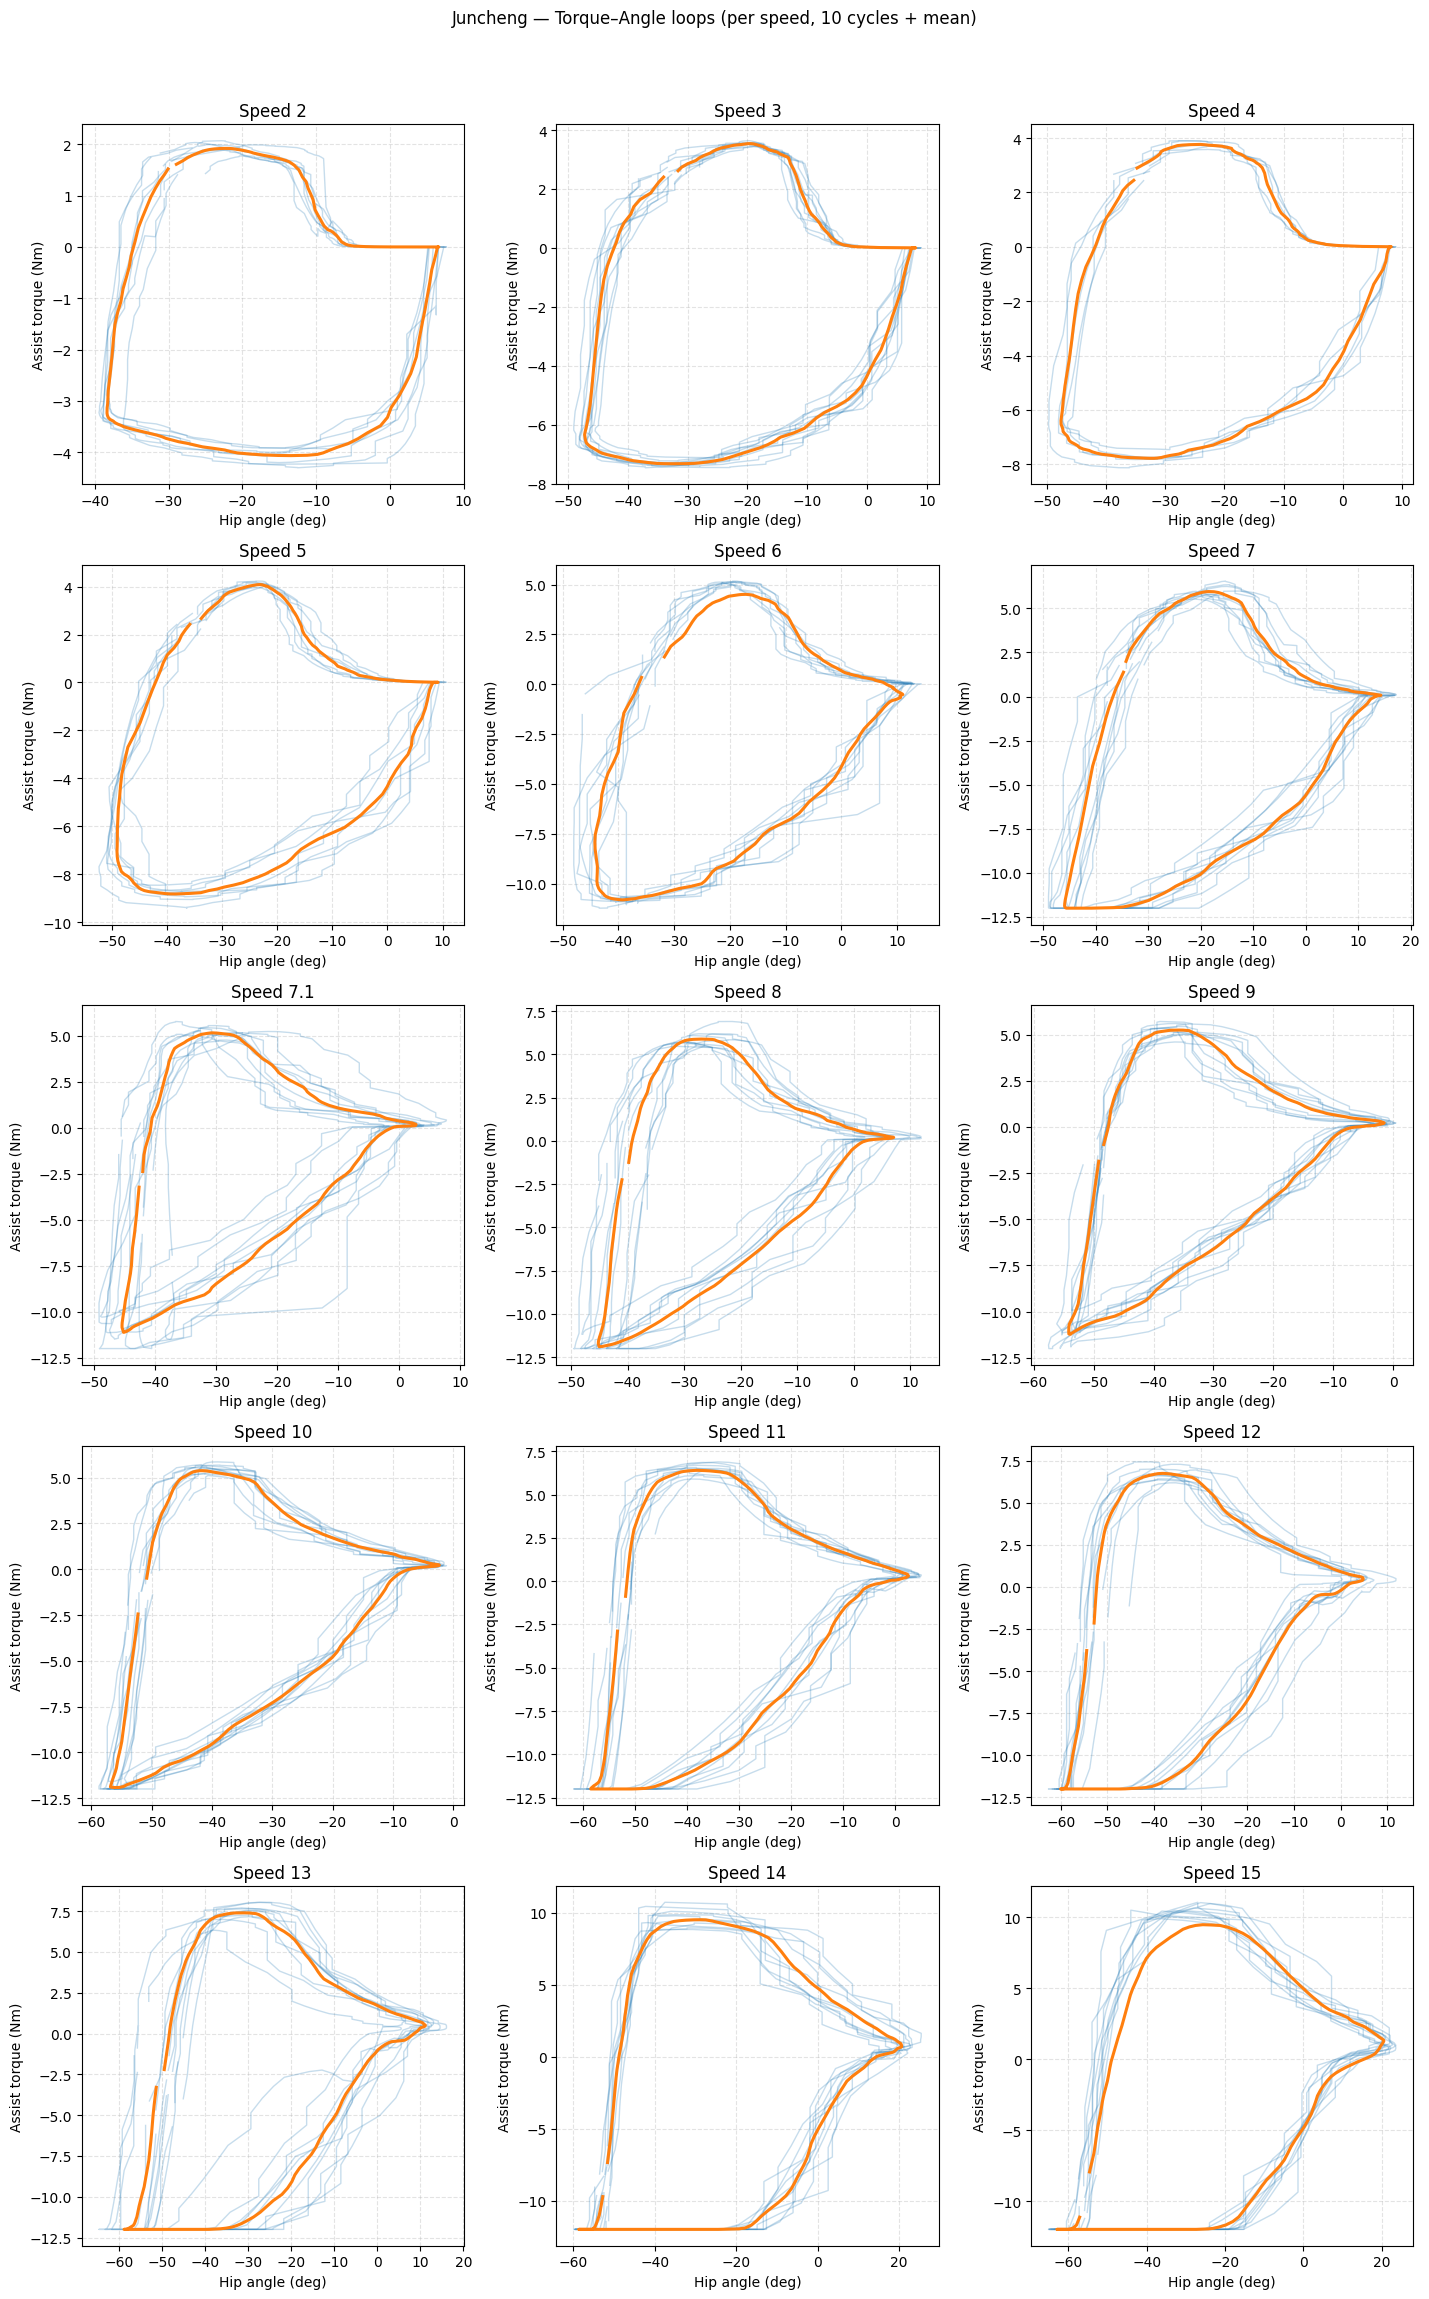

Torque–Angle 每速度做功统计（单位：J/步态周期）
    speed  n_cycles  net_work_mean_J  net_work_sd_J  pos_work_mean_J  \
0     2.0         7         3.408378       0.319359         3.492391   
1     3.0        10         7.012506       0.330213         7.250469   
2     4.0         5         7.425010       0.500563         7.683450   
3     5.0         7         8.098963       0.810659         8.496862   
4     6.0         8         8.657745       0.774304         9.195152   
5     7.0        10        10.348450       0.582662        11.249785   
6     7.1        10         6.711843       1.426731         7.124013   
7     8.0        10         7.742895       0.620897         8.368208   
8     9.0        10         6.681087       0.649447         7.397243   
9    10.0        10         7.893431       0.405167         8.569513   
10   11.0        10        10.420285       0.668254        11.295319   
11   12.0        10        11.409122       0.726345        12.361571   
12   13.0        10        12.86

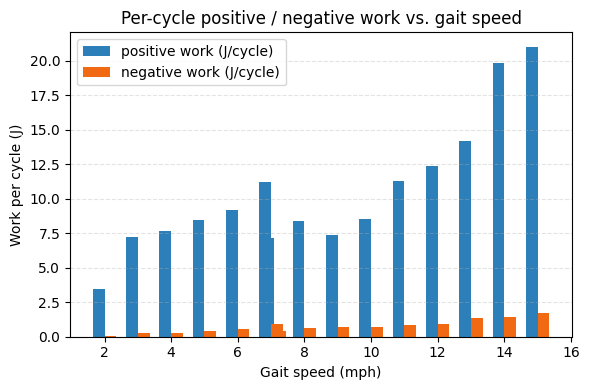

In [26]:
# -*- coding: utf-8 -*-
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===== 配置 =====
subject_dir = "Juncheng"
filename    = "wakling 1.5 2 2.5 3 3.5 stair.csv"

TIME_COL   = "Time"
ANGLE_COL  = "imu_RTx"              # deg
TORQUE_COL = "M1_torque_command"    # Nm
LABEL_COL  = "label"                # e.g., "2","3","3.5" 或 "2mile"
CYCLE_COL  = "gait_cycle"           # 1,2,3,...

MAX_CYCLES_TO_DRAW_PER_SPEED = 10   # 每速度用于绘图的最多周期数（细线）
POINTS_PER_CYCLE = 201              # 均值环路的重采样点数
SAVE_SUMMARY_CSV = True
summary_csv_path = os.path.join(subject_dir, "torque_angle_loop_summary.csv")

# ===== 小工具 =====
def normalize_label(val: str) -> str:
    s = str(val).strip().lower()
    s = s.replace("mile/h","").replace("mile","").replace("mph","")
    s = re.sub(r"[^0-9\.]", "", s)
    return s

def make_time_seconds(series: pd.Series) -> np.ndarray:
    tnum = pd.to_numeric(series, errors="coerce")
    if tnum.notna().mean() > 0.9:
        t = tnum.to_numpy(dtype=float)
        dt = np.nanmedian(np.diff(t)) if len(t) > 1 else 10.0
        return (t - t[0]) / (1000.0 if 1.0 <= dt <= 1000.0 else 1.0)
    tdt = pd.to_datetime(series, errors="coerce")
    if tdt.notna().mean() > 0.9:
        return (tdt - tdt.iloc[0]).dt.total_seconds().to_numpy()
    return np.arange(len(series), dtype=float)

def cycles_start_indices(gc: np.ndarray) -> np.ndarray:
    starts = np.where(np.diff(np.r_[np.nan, gc]) > 0)[0]
    if len(starts)==0 or starts[0]!=0:
        if not np.isnan(gc[0]): starts = np.r_[0, starts]
    return starts

def resample_by_phase(theta_deg, tau, n=POINTS_PER_CYCLE):
    """按步态相位(0..1)重采样：用于均值环路（不是按时间，而是按相位）"""
    m = np.isfinite(theta_deg) & np.isfinite(tau)
    theta = np.asarray(theta_deg, float)[m]
    tau   = np.asarray(tau, float)[m]
    if theta.size < 3:  # 数据不足
        ph = np.linspace(0,1,n)
        return ph, np.full(n, np.nan), np.full(n, np.nan)
    # 用样本索引近似相位（单调上升）
    idx = np.arange(theta.size, dtype=float)
    ph  = idx / idx[-1]
    ph_rs = np.linspace(0,1,n)
    theta_rs = np.interp(ph_rs, ph, theta)
    tau_rs   = np.interp(ph_rs, ph, tau)
    return ph_rs, theta_rs, tau_rs

def time_weighted_mean(x, t):
    if len(x) < 2: return np.nan
    return np.trapz(x, t) / (t[-1]-t[0])

# ===== 读取 =====
path = os.path.join(subject_dir, filename)
df = pd.read_csv(path)
for c in [TIME_COL, ANGLE_COL, TORQUE_COL, LABEL_COL, CYCLE_COL]:
    if c not in df.columns:
        raise ValueError(f"{path} 缺少列：{c}")

df["_t_s"] = make_time_seconds(df[TIME_COL])
df["_speed"] = df[LABEL_COL].astype(str).map(normalize_label)
speeds = sorted({s for s in df["_speed"] if len(s)>0}, key=lambda x: float(x))

# ===== 计算并绘制：每速度的环路 =====
rows = []  # 汇总功数据
ncols = min(3, len(speeds))
nrows = int(np.ceil(len(speeds) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(4.8*ncols, 4.5*nrows), squeeze=False)
cmap = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for si, sp in enumerate(speeds):
    ax = axes[si//ncols, si%ncols]
    sub = df[(df["_speed"]==sp) & df[CYCLE_COL].notna()].copy()
    if sub.empty:
        ax.set_title(f"{sp} (no data)"); ax.axis("off"); continue

    t    = sub["_t_s"].to_numpy(float)
    theta= pd.to_numeric(sub[ANGLE_COL], errors="coerce").to_numpy(float)   # deg
    tau  = pd.to_numeric(sub[TORQUE_COL], errors="coerce").to_numpy(float)  # Nm
    powr = None  # 如需功率法分解正/负功，下面会再算
    gc   = pd.to_numeric(sub[CYCLE_COL], errors="coerce").to_numpy(float)

    starts = cycles_start_indices(gc)
    if len(starts) < 2:
        ax.set_title(f"{sp} (no cycles)"); ax.axis("off"); continue

    # 画若干真实周期（细线）
    n_draw = min(MAX_CYCLES_TO_DRAW_PER_SPEED, len(starts)-1)
    thetas_all, taus_all = [], []
    netW_list, posW_list, negW_list = [], [], []

    for i in range(n_draw):
        a, b = starts[i], starts[i+1]
        th = theta[a:b]
        tq = tau[a:b]
        tt = t[a:b]

        # —— 环路（细线）
        ax.plot(th, tq, color=cmap[0], alpha=0.25, lw=1.0)

        # —— 做功：∮ τ dθ（净做功，J）
        th_rad = th * np.pi/180.0
        netW = np.trapz(tq, th_rad)    # Nm * rad = J
        netW_list.append(netW)

        # —— 正/负功：用功率积分（更稳健）
        vel = np.gradient(th_rad, tt)  # rad/s
        P = tq * vel                   # W
        posW = np.trapz(np.clip(P, 0, None), tt)
        negW = np.trapz(np.clip(P, None, 0), tt)  # 负数
        posW_list.append(posW)
        negW_list.append(negW)

        # 收集用于均值环路
        _, th_rs, tq_rs = resample_by_phase(th, tq, n=POINTS_PER_CYCLE)
        thetas_all.append(th_rs)
        taus_all.append(tq_rs)

    # —— 均值环路（粗线）
    TA = np.vstack(thetas_all)  # [cycles, phase]
    TT = np.vstack(taus_all)
    th_mu = np.nanmean(TA, axis=0)
    tq_mu = np.nanmean(TT, axis=0)
    ax.plot(th_mu, tq_mu, color=cmap[1], lw=2.2, label="mean loop")

    ax.set_title(f"Speed {sp}")
    ax.set_xlabel("Hip angle (deg)")
    ax.set_ylabel("Assist torque (Nm)")
    ax.grid(True, linestyle="--", alpha=0.35)

    # —— 每速度的功统计（均值 ± SD）
    rows.append({
        "speed": float(sp),
        "n_cycles": n_draw,
        "net_work_mean_J": np.mean(netW_list),
        "net_work_sd_J":   np.std(netW_list, ddof=1) if len(netW_list)>1 else np.nan,
        "pos_work_mean_J": np.mean(posW_list),
        "pos_work_sd_J":   np.std(posW_list, ddof=1) if len(posW_list)>1 else np.nan,
        "neg_work_mean_J": np.mean(negW_list),
        "neg_work_sd_J":   np.std(negW_list, ddof=1) if len(negW_list)>1 else np.nan,
    })

# 收尾子图
for k in range(len(speeds), nrows*ncols):
    axes[k//ncols, k%ncols].axis("off")

fig.suptitle(f"{subject_dir} — Torque–Angle loops (per speed, {MAX_CYCLES_TO_DRAW_PER_SPEED} cycles + mean)", y=1.02)
plt.tight_layout()
plt.show()

# ===== 汇总表 & 功率柱状图（正/负功）=====
summary = pd.DataFrame(rows).sort_values("speed")
print("Torque–Angle 每速度做功统计（单位：J/步态周期）")
print(summary)

if SAVE_SUMMARY_CSV:
    summary.to_csv(summary_csv_path, index=False)
    print(f"✔ 已保存：{summary_csv_path}")

# 画：速度 vs 平均正/负功（与 Fig.15a 风格一致，但单位是每周期J）
fig, ax = plt.subplots(figsize=(6,4))
x = summary["speed"].to_numpy()
w = 0.35
ax.bar(x - w/2, summary["pos_work_mean_J"], width=w, color="#2C7FB8", label="positive work (J/cycle)")
ax.bar(x + w/2, np.abs(summary["neg_work_mean_J"]), width=w, color="#F16913", label="negative work (J/cycle)")
ax.set_xlabel("Gait speed (mph)")
ax.set_ylabel("Work per cycle (J)")
ax.set_title("Per-cycle positive / negative work vs. gait speed")
ax.legend()
ax.grid(True, axis="y", linestyle="--", alpha=0.35)
plt.tight_layout()
plt.show()


In [ ]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt

SUBJECTS = ["Qianhe", "Miki", "dongming", "wanqi"]
BASENAME = "walking 2 3 3.5.csv"

TIME_CANDIDATES = ["Time", "time", "timestamp"]
ANGLE_COLS = ["imu_RTx", "imu_LTx"]      # 需要求导的角度列
CUTOFF_HZ = 2.0                          # 低通截止频率
FILTER_ORDER = 4

def find_time_col(df):
    for c in df.columns:
        if c in TIME_CANDIDATES or c.lower().startswith("time"):
            return c
    raise ValueError("未找到时间列（如 Time/time/timestamp）")

def time_to_seconds(t_series: pd.Series) -> np.ndarray:
    t = pd.to_numeric(t_series, errors="coerce").to_numpy(dtype=float)
    t = t - np.nanmin(t)
    dt = np.nanmedian(np.diff(t[np.isfinite(t)])) if len(t) > 1 else np.nan
    if np.isnan(dt) or dt == 0:
        # 兜底：用索引代替时间（避免除以 0）
        return np.arange(len(t), dtype=float)
    # 判断是否是毫秒
    if dt > 1.0:
        t = t / 1000.0
    return t

def finite_diff(y, t):
    return np.gradient(y, t)
def moving_average(x, window_size=15):
    """
    简单滑动平均平滑（中心对齐，NaN 自动忽略）
    window_size 越大越平滑；建议范围 5~25
    """
    x = np.asarray(x, dtype=float)
    nans = ~np.isfinite(x)
    if nans.any():
        idx = np.arange(len(x))
        x[nans] = np.interp(idx[nans], idx[~nans], x[~nans])
    kernel = np.ones(window_size) / window_size
    y = np.convolve(x, kernel, mode="same")
    y[nans] = np.nan
    return y

def butter_lowpass(x, cutoff_hz, fs, order=4):
    # 防御：确保 cutoff < Nyquist
    nyq = 0.5 * fs
    c = min(cutoff_hz, nyq * 0.99) if nyq > 0 else cutoff_hz
    if c <= 0 or nyq <= 0:
        return x
    b, a = butter(order, c / nyq, btype="low", analog=False)
    # filtfilt 不能出现 NaN；先线性插值再滤波，最后把原 NaN 放回去
    x = np.asarray(x, dtype=float)
    nans = ~np.isfinite(x)
    if nans.any():
        idx = np.arange(len(x))
        x[nans] = np.interp(idx[nans], idx[~nans], x[~nans])
    # padlen 防御：数据太短时直接返回原始
    padlen = 3 * max(len(a), len(b))
    if len(x) <= padlen:
        return x
    xf = filtfilt(b, a, x)
    xf[nans] = np.nan  # 按需放回 NaN（也可不放回）
    return xf

def process_file(file_path):
    if not os.path.exists(file_path):
        print(f"❌ 找不到文件：{file_path}")
        return
    df = pd.read_csv(file_path)
    time_col = find_time_col(df)
    t = time_to_seconds(df[time_col])
    # 采样率
    dt = np.nanmedian(np.diff(t[np.isfinite(t)])) if len(t) > 1 else np.nan
    fs = 1.0 / dt if (dt and dt > 0) else np.nan
    print(f"→ {file_path} | 采样率估计: {fs:.2f} Hz")

    for col in ANGLE_COLS:
        if col not in df.columns:
            print(f"  ⚠️ 缺少列 {col}，跳过该列")
            continue
        y = pd.to_numeric(df[col], errors="coerce").to_numpy(dtype=float)
        vel = finite_diff(y, t)               # deg/s
        vel *= np.pi/180.0
        if np.isfinite(fs):
            # vel = butter_lowpass(vel, CUTOFF_HZ, fs, FILTER_ORDER)
            vel = moving_average(vel, window_size=3)  # ← 可根据实际调整窗口大小

        df[f"{col}_velocity"] = vel

    out_path = os.path.join(os.path.dirname(file_path),
                            os.path.basename(file_path).replace(".csv", "_with_velocity.csv"))
    df.to_csv(out_path, index=False)
    print(f"✅ 输出：{out_path}")
    print(f"   新增列：{[f'{c}_velocity' for c in ANGLE_COLS]}")

# 批量处理
for subj in SUBJECTS:
    process_file(os.path.join(subj, BASENAME))


→ Qianhe/walking 2 3 3.5.csv | 采样率估计: 100.00 Hz
✅ 输出：Qianhe/walking 2 3 3.5_with_velocity.csv
   新增列：['imu_RTx_velocity', 'imu_LTx_velocity']
→ Miki/walking 2 3 3.5.csv | 采样率估计: 100.00 Hz
✅ 输出：Miki/walking 2 3 3.5_with_velocity.csv
   新增列：['imu_RTx_velocity', 'imu_LTx_velocity']
→ dongming/walking 2 3 3.5.csv | 采样率估计: 100.00 Hz


/var/folders/bk/9h6f82g55bx0xch3f1yztl5w0000gn/T/ipykernel_82701/1106899955.py:75: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


✅ 输出：dongming/walking 2 3 3.5_with_velocity.csv
   新增列：['imu_RTx_velocity', 'imu_LTx_velocity']
→ wanqi/walking 2 3 3.5.csv | 采样率估计: 100.00 Hz
✅ 输出：wanqi/walking 2 3 3.5_with_velocity.csv
   新增列：['imu_RTx_velocity', 'imu_LTx_velocity']
